In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../..")
from utils import utils
from utils.plotting_utils import plots

In [2]:
def prepare_table(filepath):
    df = pd.read_excel(filepath)
    df["Score"] *= 100
    
    df[["Train-Group", "Test-Group"]] = df[["Train-Language", "Test-Language"]].applymap(lambda x: utils.lang_to_group[x])
    df["Transfer"] = df[["Train-Language", "Test-Language"]].apply(
        lambda x: "In-language" if x["Train-Language"] == x["Test-Language"] else "Cross-language", 
        axis=1
    )
    df = df.groupby(["Train-Group", "Train-Language", "Test-Group", "Model", "Size", "Transfer"], 
                    as_index=False, sort=False).mean()
    df["Transfer-Type"] = df[["Train-Group", "Test-Group"]].apply(
        lambda x: "Intra-group" if x["Train-Group"] == x["Test-Group"] else "Inter-group", 
        axis=1
    )
    df = df.groupby(["Model", "Size", "Transfer-Type", "Transfer"], as_index=False, sort=False).mean()
    
    df = df.pivot_table(index=["Model", "Size", "Transfer-Type"], columns="Transfer", values="Score")
    df = df.fillna(method="backfill")
    df = df.reset_index()
    df = df.replace({"mbert": "mBERT", "xlm-roberta": "XLM-R"})
    df["Transfer-Loss"] = df["In-language"] - df["Cross-language"]
    df["Size"] /= 1000
    
    return df

In [3]:
def make_plot(df, y, ylabel, title, save_to=None):
    plots.prepare_sns()
    sns.set_context("paper", font_scale=3)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    sns.lineplot(
        x="Size",
        y=y,
        data=df,
        style="Model",
        hue="Transfer-Type",
        markers=["o", "o"],
        markersize=12,
        linewidth=2.5,
        palette=sns.color_palette("colorblind", n_colors=2), 
        ax=ax
    )

    leg = ax.get_legend()
    leg.set_bbox_to_anchor((0.85, 0.25, 0.5, 0.5))

    for i in range(6):
        if i == 1:
            leg.legendHandles[i].set_linewidth(5)
        else:
            leg.legendHandles[i].set_linewidth(2.5)

    plt.setp(ax.lines[:2], linewidth=5)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Training Examples (x$10^3$)")

    sns.despine()
    plt.show()
    if save_to:
        fig.savefig(save_to, dpi=400, bbox_inches="tight")
    plt.close()

### PoS - German

In [4]:
df = prepare_table("results/results_de_large.xlsx")

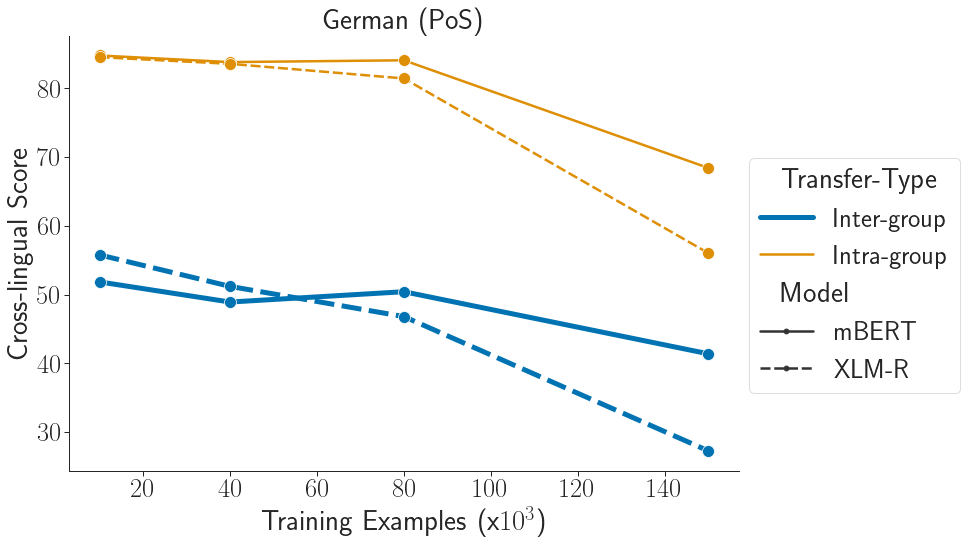

In [152]:
make_plot(df, y="Cross-language", ylabel="Cross-lingual Score", title="German (PoS)", 
          save_to="plots/size_vs_cross_score_german.pdf")

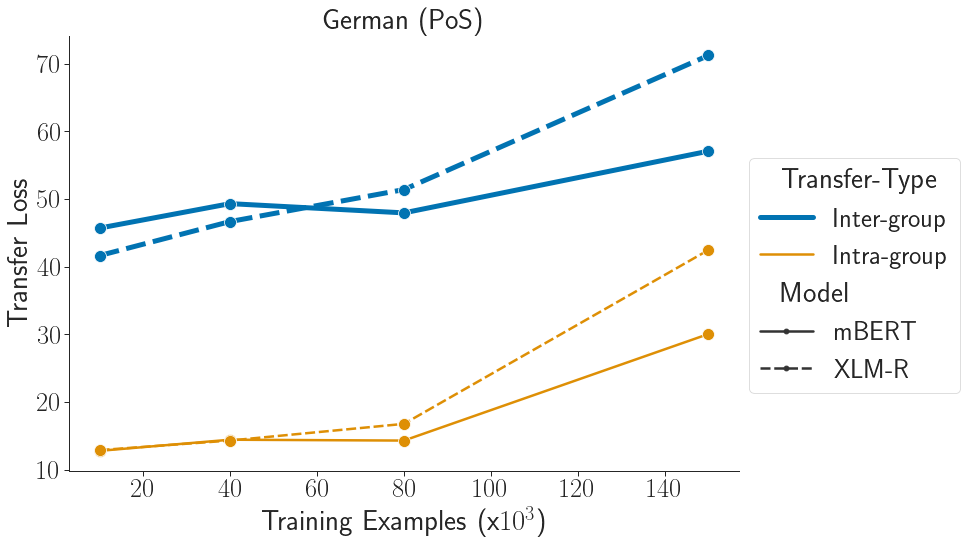

In [155]:
make_plot(df, y="Transfer-Loss", ylabel="Transfer Loss", title="German (PoS)",
          save_to="plots/size_vs_transfer_loss_german.pdf")

### Sentiment - Korean

In [21]:
df = prepare_table("results/results_ko_large.xlsx")

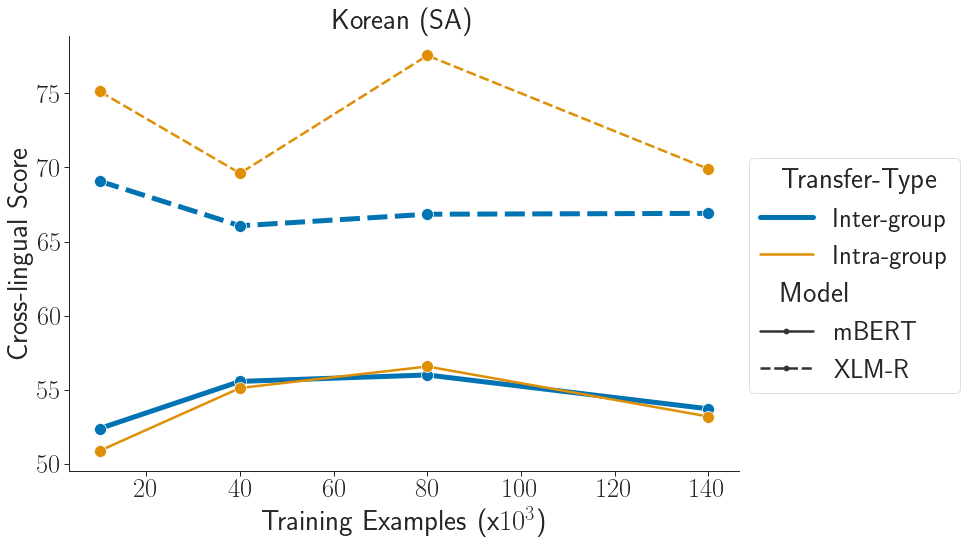

In [158]:
make_plot(df, y="Cross-language", ylabel="Cross-lingual Score", title="Korean (SA)", 
          save_to="plots/size_vs_cross_score_korean.pdf")

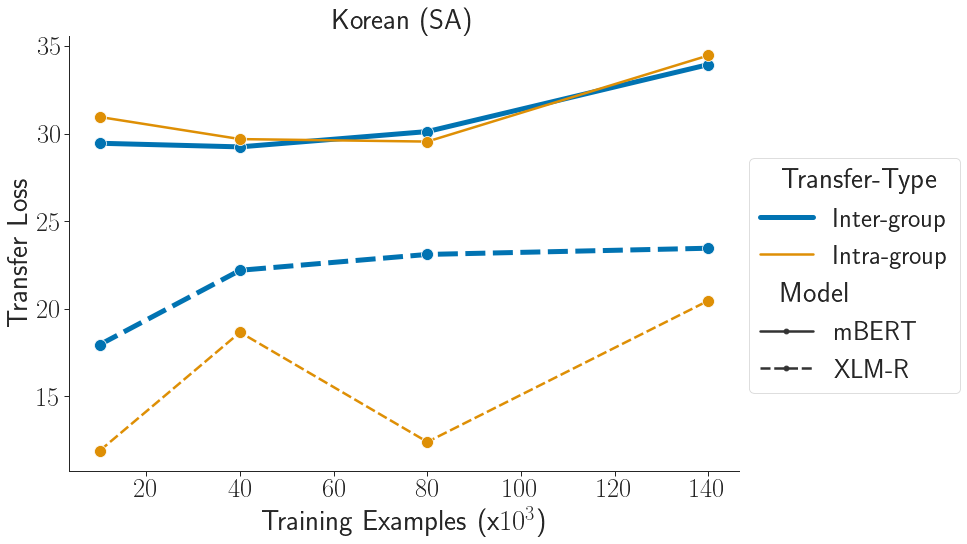

In [160]:
make_plot(df, y="Transfer-Loss", ylabel="Transfer Loss", title="Korean (SA)", 
          save_to="plots/size_vs_transfer_loss_korean.pdf")